# DSCI 100 Group Project - Predicting Housing Prices - Group Project Proposal
### Group Members: David Chen, Catherine Jiang, Chanon Mallikamas, Christopher Xu



### Introduction 
With the housing market being such a large share of the GDP, changes in the price and consumer outlook on the housing market can sway an economy. Hence, having the tools to accurately predict such a significant aspect of the economy can be highly beneficial. For a specific house, it is important for sellers to determine an adequate price to maximize their profit. 
Additionally, by identifying the price range of a house, it allows buyers to gauge the competitiveness of a house on the market and its long-term value. Therefore, this dataset exhibits valuable information and real-life applications. Using this predictive question, we can take a representative data set for the whole real estate population and infer characteristics of the whole population.



### Question: Can we use the data of past housing prices to predict the price of a new house?

Dataset: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

The dataset that we are using in our project is called Housing Prices Dataset, which is taken from houses that were previously sold. The information provided in this dataset includes numerical factors such as: 
price 
area (square feet)
bedrooms
bathrooms
stories 
Categorical factors such as:
mainstreet location
existence of a basement/guesthouse


Preliminary exploratory data analysis:

In [1]:
### Run this cell before continuing. (From worksheet_viz)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# - Demonstrate that the dataset can be read from the web into R 

# We downloaded the dataset as a CSV file from Kaggle and put it in our data folder
# Here we have read the file using read_csv
housing_data = read_csv("data/housingdata.csv", show_col_types = FALSE)

# Here we see that the data follows the conditions of being tidy.
housing_data

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


In [3]:
# - Clean and wrangle your data into a tidy format
# To make the categorical variables useable with our model, we will convert them into numerical values

# Here, the yes/no values are changed so that yes = 1 and no = 0
housing_data <- housing_data |>
    mutate(mainroad = ifelse(mainroad == "yes", 1, 0)) |>
    mutate(guestroom = ifelse(guestroom == "yes", 1, 0)) |>
    mutate(hotwaterheating = ifelse(hotwaterheating == "yes", 1, 0)) |>
    mutate(airconditioning = ifelse(airconditioning == "yes", 1, 0)) |>
    mutate(basement = ifelse(basement == "yes", 1, 0)) |>
    mutate(prefarea = ifelse(prefarea == "yes", 1, 0))

# ordinal encoding on furnishingstatus
# "unfurnished" = "0", "semi-furnished" = "1", "furnished" = "2"
housing_data$furnishingstatus <- recode_factor(housing_data$furnishingstatus, "unfurnished" = "0", "semi-furnished" = "1", "furnished" = "2") 
housing_data$furnishingstatus <- as.numeric(housing_data$furnishingstatus)

housing_data

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
13300000,7420,4,2,3,1,0,0,0,1,2,1,3
12250000,8960,4,4,4,1,0,0,0,1,3,0,3
12250000,9960,3,2,2,1,0,1,0,0,2,1,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1750000,3620,2,1,1,1,0,0,0,0,0,0,1
1750000,2910,3,1,1,0,0,0,0,0,0,0,3
1750000,3850,3,1,2,1,0,0,0,0,0,0,1


In [4]:
# Split the data into training and test data

housing_split <- initial_split(housing_data, prop = 3/4, strata = price)  
housing_train <- training(housing_split)   
housing_test <- testing(housing_split)

In [5]:
# We decided to use a table that gave the mean of each of the features in our dataset.  
tbl_means <- housing_train |>
                summarise(across(area:furnishingstatus, mean))
print("Table of Mean values of each category")
tbl_means

[1] "Table of Mean values of each category"


area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5156.926,2.968059,1.289926,1.835381,0.8501229,0.1842752,0.3562654,0.05159705,0.3292383,0.7223587,0.2457002,1.918919


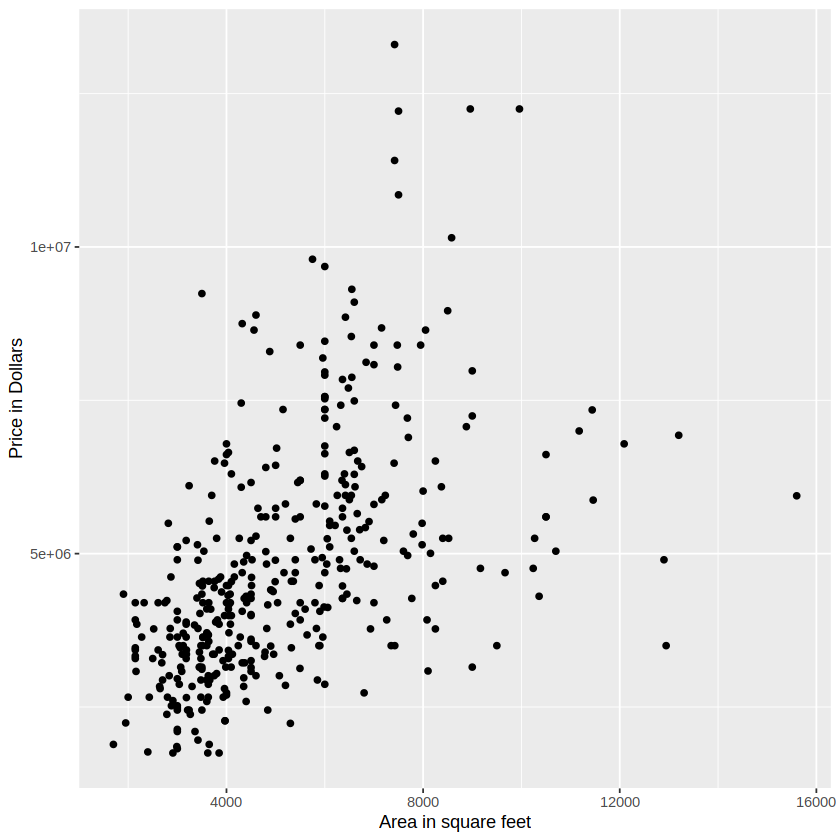

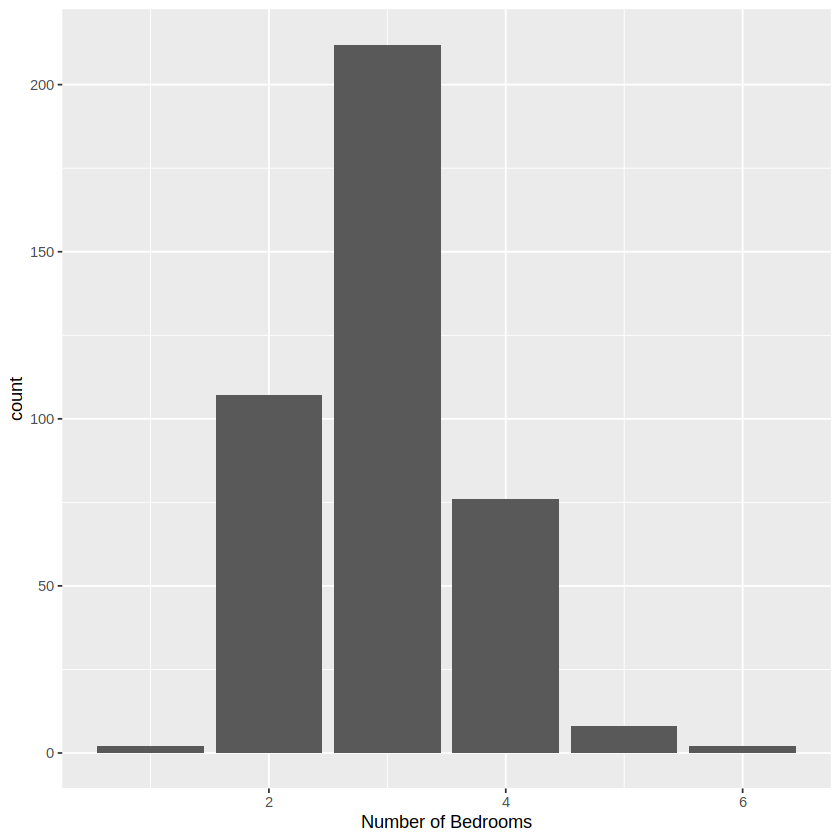

In [6]:
# We decided to use scatterplots and bar plots to visualize the relationship between the more relevant features 
# Scatterplots for area, bedrooms and prefarea

area_plot <- ggplot(housing_train, aes(x = area, y = price)) + 
                geom_point() + 
                labs(x="Area in square feet", y="Price in Dollars")
area_plot

bedrooms_plot <- ggplot(housing_train, aes(x = bedrooms)) + 
                geom_bar() + 
                labs(x="Number of Bedrooms")
bedrooms_plot




### Methods:  
We plan to use a Linear Regression Model and KNN regression model to make our predictions. We will average the results of both models to get a more robust prediction that is less prone to overfitting, or fitting to or noise in the training data. We will first assume equal importance for all variables and at later stages, we will put a greater emphasis on the the more relevant factors.

The features that we found to be most important are the area, number of bedrooms, number of bathrooms, prefarea (whether the house is in a preferable area) and the furnishing status, so we will be more likely to place more importance on features and use them in our model. To prevent our model from placing too much importance on one specific feature, we will be standardizing the numeric features such that each of the factors that we use will have an equal weighting for the model. We will also be carrying out cross-validation in order to have a robust assessment of our model and avoid overfitting the models we use


### Expected outcomes and significance: - 
Some of our expected outcomes include the following:
- We might see varying relationships between price and some of the other features such as area, bedrooms or stories 
- The model may perform well on the training data, but it might have a lower performance on new data

### What impact could such findings have?
- Setting a price in the housing market according to the features of the house is extremely important. If we do not use regression analysis to set the price of the house, the house might not be sold if the price is too high or the house may be sold at a loss if the price is too low.

### What future questions could this lead to?
- How can we use this model/its predictions in other scenarios with added variables or new restrictions based on the targeted audience? Would we achieve better results with different methods?
- Can the regression model used in this study yield the same results in other markets?
